# UPML
## Unification & Pattern Matching Language

(c) Dmitry Ponyatov <<dponyatov@gmail.com>> MIT 2019 All rights reserved

github: https://bitbucket.org/ponyatov/UPML

In [1]:
# %pip install -U pip
# %pip install -U ply graphviz jupyter

In [2]:
import os,sys

# Universal data type: directed hypergraph

In [3]:
class Frame:

    def __init__(self,V):
        # class tag /required for PLY library/
        self.type = self.__class__.__name__.lower()
        # scalar value: name, string, number,..
        self.val  = V
        # attributes = edges to subgraphs = lookup vocabulary
        self.slot = {}
        # nested elements = ordered container = AST = stack
        self.nest = []

In [4]:
hello = Frame('hello') ; print(hello)

## text dump

In [5]:
class Frame(Frame):

    def __repr__(self): return self.dump()

    # full tree dump
    def dump(self,depth=0,prefix=''):
        # head
        tree = self._pad(depth) + self.head(prefix)
        # infinite recursion block
        if not depth: Frame._dump = []
        if self in Frame._dump: return tree + ' _/'
        else: Frame._dump.append(self)
        # slot{}s
        for i in self.slot:
            tree += self.slot[i].dump(depth+1,'%s = '%i)
        # nest[]ed
        idx = 0
        for j in self.nest:
            tree += j.dump(depth+1,'%i: '%idx) ; idx += 1
        # subtree dump
        return tree

    # <T:V> header only dump
    def head(self,prefix=''):
        return '%s<%s:%s> id:%x' % (prefix,self.type,self._val(),id(self))
    
    def _pad(self,depth):
        return '\n' + ' '*4 * depth
    def _val(self):
        return '%s' % self.val

In [6]:
hello = Frame('hello') ; print(hello)


<frame:hello> id:7fac60338b38


## graph plot (in jupyter notebook)

In [7]:
import graphviz

class Frame(Frame):

    def plot(self,dot=None,parent=None,link='',color='black'):
        if not dot:
            dot = graphviz.Digraph() ; dot.attr(rankdir='LR')
            Frame._plot = []
        # node
        dot.node('%s'%id(self),label='%s:%s'%(self.type,self._val()))
        if parent: dot.edge('%s'%id(parent),'%s'%id(self),label='%s'%link,color=color)
        # infinite recursion block
        if self in Frame._plot: return dot
        else: Frame._plot.append(self)
        # sub slot{}s
        for i in self.slot:
            dot = self.slot[i].plot(dot,parent=self,link=i,color='blue')
        # nest[]ed
        idx = 0
        for j in self.nest:
            dot = j.plot(dot,parent=self,link=idx,color='green') ; idx += 1
        # subplot
        return dot


<frame:hello> id:7fac603449e8


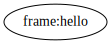

In [8]:
hello = Frame('hello') ; print(hello) ; hello.plot()

## operators

In [9]:
class Frame(Frame):

    # A[key]
    def __getitem__(self,key):
        return self.slot[key]

    # A[key] = B
    def __setitem__(self,key,that):
        if callable(that): self[key] = Cmd(that) ; return self
        self.slot[key] = that ; return self

    # A << B -> A[B.type] = B
    def __lshift__(self,that):
        if callable(that): return self << Cmd(that)
        self[that.type] = that ; return self

    # A >> B -> A[B.val] = B
    def __rshift__(self,that):
        if callable(that): return self >> Cmd(that)
        self[that.val ] = that ; return self

    # A // B stack push
    def __floordiv__(self,that):
        if isinstance(that,str): return self // String(that)
        self.nest.append(that) ; return self


<frame:hello> id:7fac603456a0
    0: <frame:world> id:7fac603457b8


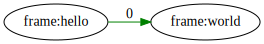

In [10]:

hello = Frame('hello') // Frame('world') ; print(hello) ; hello.plot()

In [11]:
class Frame(Frame):

    def pop(self): return self.nest.pop(-1)
    def top(self): return self.nest[-1]

# Primitive data: symbol, string, numbers

In [12]:
class Primitive(Frame): pass
class Symbol(Primitive): pass
class String(Primitive): pass

# EDS: Executable Data Structure

In [13]:
class Active(Frame): pass

### Stack Virtual Machine


<vm:UPML> id:7fac60338f28
    vm = <vm:UPML> id:7fac60338f28 _/


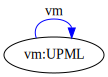

In [14]:
# Virtual Machine
class VM(Active): pass

vm = VM('UPML') ; vm << vm

print(vm) ; vm.plot()

### Commands: wrapped functions applied to VM context

In [15]:
# Command: wrapper for function F(context)
class Cmd(Active):
    def __init__(self, F):
        Active.__init__(self,F.__name__)
        self.fn = F
    def eval(self,ctx):
        self.fn(ctx)

**Context** is some stack VM: stack for data manipulations, and environment (vocabulary) for variables lookup and storage.

As *any `Frame` has `nest[]` as a stack and `slot{}` as vocabulary*, in the `metaL` model we can apply any command to any data.

# FORTH-like concatenative language

It can be easier to use a special language than Python, FORTH is the simplest programming language from the viewpoint of implementation.

### no-syntax lexer uses PLY library

In [16]:
import ply.lex  as lex

tokens = ['symbol']

t_ignore         = ' \t\r\n'
t_ignore_comment = r'[\#\\].*'

def t_symbol(t):
    r'[`]|[^ \t\r\n\#\\]+'
    return Symbol(t.value)

def t_error(t): raise SyntaxError(t)

## Interpreter

It's the classical `WORD-FIND-EXECUTE` loop

In [19]:
def WORD(ctx):
    token = ctx.lexer.token()
    if token: ctx // token
    return token
vm['`'] = WORD ; vm >> WORD

def FIND(ctx):
    token = ctx.pop()
    try:             ctx // ctx[token.val] ; return True
    except KeyError: ctx // token          ; return False
vm >> FIND

def EVAL(ctx): ctx.pop().eval(ctx)
vm['EXECUTE'] = EVAL

def INTERP(ctx):
    ctx.lexer = lex.lex() ; ctx.lexer.input(ctx.pop().val)
    while True:
        if not WORD(ctx): break
        if isinstance(ctx.top(),Symbol):
            if not FIND(ctx): raise SyntaxError(ctx.top())
        EVAL(ctx)
        print(ctx.plot().view())
vm['INTERPRET'] = INTERP

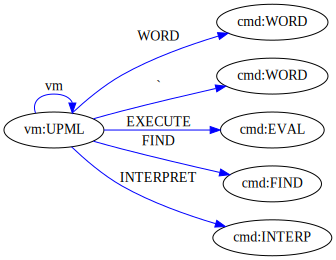

In [20]:
vm.plot()